# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Predicting Salary with the features factors Dataset
This notebook demonstrates the entire process of building a predictive model to suggest the salary range for job seekers. All the processes involving defining problems, discovering dataset, developing model, and deploying into production have been divided into main sections. Salary range tends to vary, depending on many factors such as experiences, education, previous job title, etc. This predictive analysis aims to build a scalable and deployable model to predict salary based on different factors.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split



In [2]:
# My information
__author__ = " Cho_Hang"
__email__ = "joench1993@gmail.com"

In [3]:
## helper function 

#load csv data files 
def load_file(file):
    return pd.read_csv(file)

#merge data
def merge_data(df1, df2, key):
    return df1.merge(df2, on = key)

#clean data function
def clean_data(df):
    #removes rows where salary equals to zero
    return df[df.salary > 0]

#create visualize_features function
def visualize_features(df, col, gb = 'salary'):
    plt.figure(figsize = (18,8))
    if df[col].dtype == 'int64':
        #if column is numeric, plot a boxplot and the relationship between this feature and salary
        plt.subplot(121)
        mean = df.groupby(col)[gb].mean()
        std = df.groupby(col)[gb].std()
        mean.plot()
        plt.ylabel(gb)
        plt.fill_between(range(len(std.index)), mean.values - std.values, mean.values + std.values, alpha = 0.1)
        plt.subplot(122)
        sns.boxplot(df[col])
    else:
        #if column is categorical, plot a boxplot of salary grouped by the category's values
        mean = df.groupby(col)[gb].mean()
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        sns.boxplot(x = col, y = gb, data = df)
    plt.ylabel(gb)
    plt.show()

def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)#,ignore_index=False)

def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [4]:
!ls -lh data/

total 269304
-rwxr-xr-x@ 1 ngjo  staff    56M Oct  8  2016 test_features.csv
-rwxr-xr-x@ 1 ngjo  staff    56M Oct  8  2016 train_features.csv
-rwxr-xr-x@ 1 ngjo  staff    20M Oct  8  2016 train_salaries.csv


In [69]:
train_fea = pd.read_csv('data/train_features.csv')
train_salary = pd.read_csv('data/train_salaries.csv')
test_set = pd.read_csv('data/test_features.csv')

In [6]:
test_set.shape

(1000000, 8)

In [7]:
train_fea.shape

(1000000, 8)

In [8]:
train_salary.shape

(1000000, 2)

### ---- 3 Inspect and clean the data ----

In [9]:
train_fea.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

In [10]:
train_salary.isnull().any()

jobId     False
salary    False
dtype: bool

In [11]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [12]:
train_fea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [13]:
train_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [14]:
# Merging the dataset train_salary and train_fea
train_merged = pd.merge(train_fea,train_salary, how='left', on='jobId')

In [15]:
# Look for duplicated values.
train_merged.duplicated().any()

False

After some preprocessing and dataset, the merged training dataset looks clean.

### ---- 4 Explore the data (EDA) ----

In [16]:
train_merged.shape

(1000000, 9)

In [17]:
train_merged.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [18]:
#review the summary statistics of the new merged dataset
train_merged.describe(include = 'all')

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000.000000,1000000.000000,1000000.000000
unique,1000000,63,8,5,9,7,NaN,NaN,NaN
top,JOB1362684866173,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB,NaN,NaN,NaN
freq,1,16193,125886,236976,532355,143206,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,11.992386,49.529260,116.061818
std,NaN,NaN,NaN,NaN,NaN,NaN,7.212391,28.877733,38.717936
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,25.000000,88.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,50.000000,114.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,75.000000,141.000000


In [19]:
# Check if every record are unique
train_merged.jobId.nunique() == len(train_merged)

True

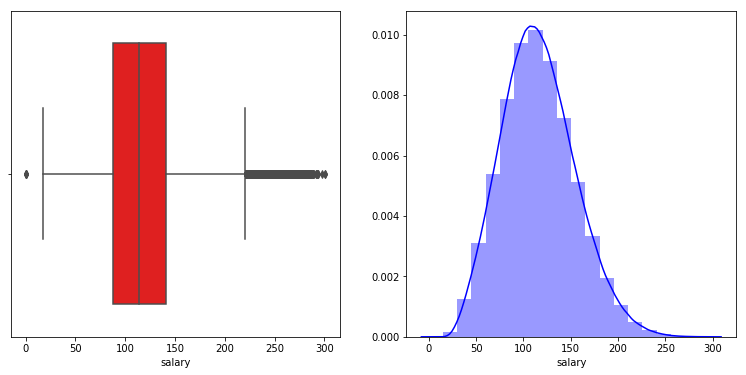

In [20]:
# Check the distribution of the target variable. 
plt.figure(figsize = (13, 6))
plt.subplot(1,2,1)
sns.boxplot(train_merged.salary,color = 'r')
plt.subplot(1,2,2)
sns.distplot(train_merged.salary, bins=20,color = 'b')
plt.show()

In [21]:
# Draw 10% sample from the original dataset for fasting training and ensure a more normally distributed target variable
train_subset = train_merged.sample(n=100000,replace = True)

In [22]:
train_subset.salary.describe()

count    100000.000000
mean        115.832630
std          38.630203
min          20.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         279.000000
Name: salary, dtype: float64

In [23]:
def plot_feature(df, col):
    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data=df.sort_values('salary'))
    
    plt.xticks(rotation=45)
    plt.ylabel('Salaries')
    plt.show()

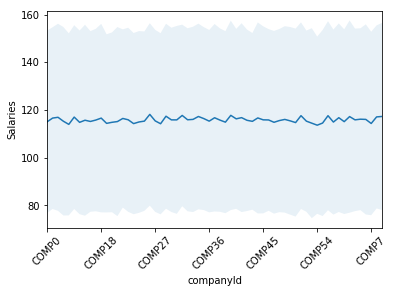

In [24]:
plot_feature(train_subset,'companyId')

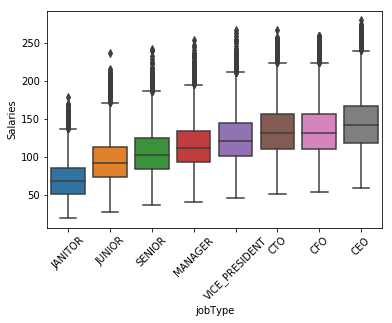

In [25]:
plot_feature(train_subset,'jobType')

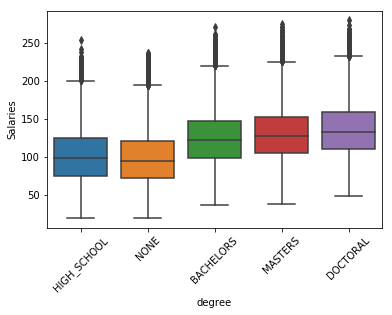

In [26]:
plot_feature(train_subset,'degree')

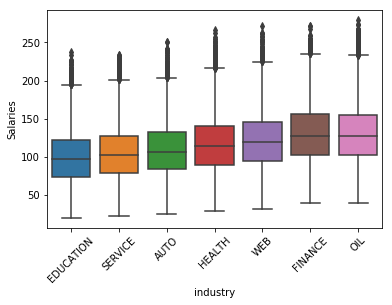

In [27]:
plot_feature(train_subset,'industry')

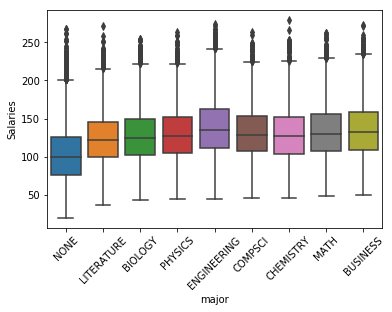

In [28]:
plot_feature(train_subset,'major')

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.002932,0.372112
milesFromMetropolis,0.002932,1.000000,-0.297904
salary,0.372112,-0.297904,1.000000


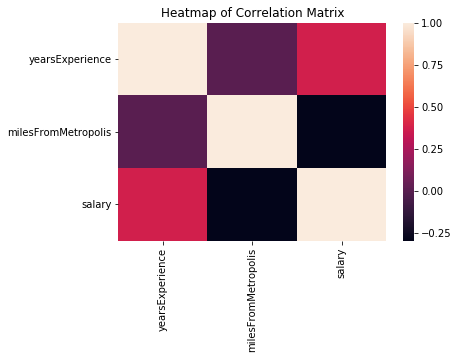

In [29]:
#look for correlation between each feature and the target
corr = train_subset.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

Text(0, 0.5, 'Count')

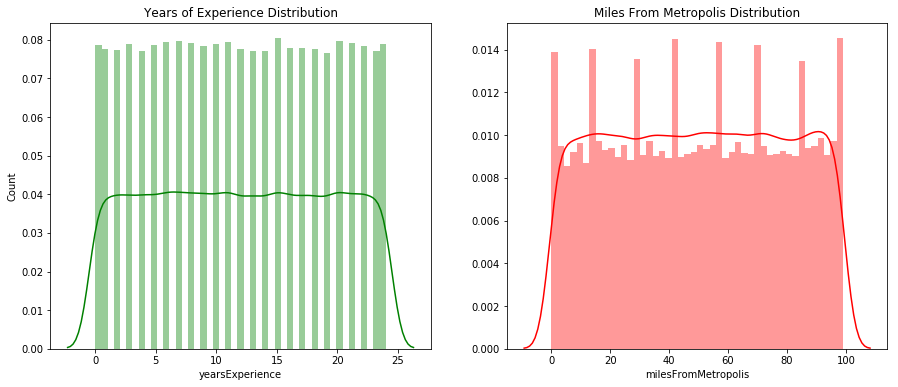

In [30]:
# Check distribution for years of experience
f, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.distplot(train_subset.yearsExperience, color="g", ax=axes[0]).set_title('Years of Experience Distribution')
axes[0].set_ylabel('Count')

sns.distplot(train_subset.milesFromMetropolis, color="r", ax=axes[1]).set_title('Miles From Metropolis Distribution')
axes[0].set_ylabel('Count')


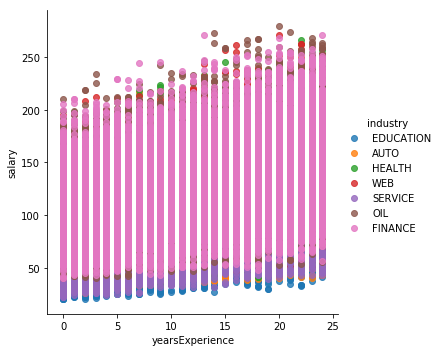

In [31]:
sns.lmplot(x='yearsExperience', y='salary', data=train_subset,
           fit_reg=False, # No regression line
           hue='industry')   

In [70]:
## Convert object to numerical for models prediction
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for item in train_subset:
        if train_subset[item].dtype == object:
            train_subset[item] = le.fit_transform(train_subset[item])
        else:
            pass
for item in test_set:
        if test_set[item].dtype == object:
            test_set[item] = le.fit_transform(test_set[item])
        else:
            pass


### ---- 5 Establish a baseline ----

In [33]:
# The following script divides data into attributes and labels:
X = train_subset.drop(['jobId','companyId','salary'],axis=1)
y = train_subset['salary']

In [34]:
# Split into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

In [35]:
# Training the Algorithm
model_1 = RandomForestRegressor(n_jobs = -1,oob_score=True, random_state=40)

In [36]:
# Fiting data
model_1.fit(X_train,y_train)

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=True, random_state=40, verbose=0, warm_start=False)

In [37]:
# Prediction
y_pred = model_1.predict(X_test) 
y_pred

array([109.8       , 150.2       ,  71.12666667, ..., 150.5       ,
       123.7       , 151.        ])

In [38]:
# Mean square error will be used to define my model performance
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

Mean Squared Error: 433.7964607022684


### ---- 6 Hypothesize solution ----

The mean square error for the baseline model is 450, I am planning to tune the model and find the optimize depth_tree,n_estimators, and min_leaf.
The other solution to improve the error is to employ gradient boosting, and neural network. 


Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

### Feature engineering 

jobType                0.374401
degree                 0.038320
major                  0.083721
industry               0.096811
yearsExperience        0.197631
milesFromMetropolis    0.209116
dtype: float64


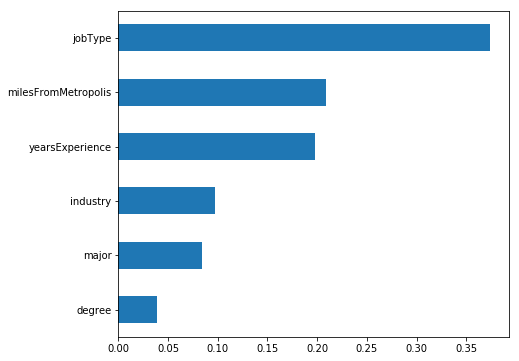

In [39]:
#Using random forest regressor to check the feature importance.
feature_importances = pd.Series(model_1.feature_importances_, index=X.columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))



### ---- 8 Create models ---- 

#### Building Linear Regression Model 

In [40]:
lr = LinearRegression()
lr.fit(X_train,y_train)
# Prediction
y_pred_1 = lr.predict(X_test) 
y_pred_1

array([147.50253797, 166.84733366,  48.51964689, ..., 121.43269747,
       119.8933536 , 164.9870274 ])

In [41]:
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_1))

Mean Squared Error: 916.6197579926621


### Tuning Random Forest Model

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 depth
MSE Train:  282.5592536418651
MSE Test:  759.1483144461452
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 depth
MSE Train:  136.21223709471255
MSE Test:  520.5383356019813
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 depth
MSE Train:  105.72842344399919
MSE Test:  474.06438143468375
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


10 depth
MSE Train:  83.36683811882955
MSE Test:  436.8076852309972
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


20 depth
MSE Train:  71.75898790057909
MSE Test:  418.95314504928274
 


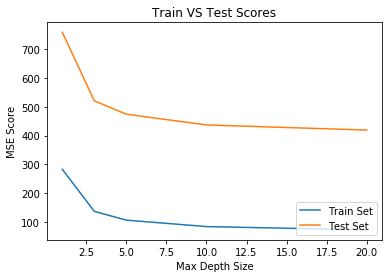

In [42]:
# Tuning max_depth_size
results  = []
results2 = []
max_depth_size  = [1,3,5,10,20]

for depth in max_depth_size:
    model = RandomForestRegressor(depth,n_jobs =-1 ,oob_score=True, random_state=44)
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(depth, 'depth')
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    mse1 = mean_squared_error(y_train, pred)
    mse2 = mean_squared_error(y_test, pred2)
    print('MSE Train: ', mse1)
    print('MSE Test: ', mse2)
    results.append(mse1)
    results2.append(mse2)
    print (" ")

plt.plot(max_depth_size, results, label='Train Set')
plt.plot(max_depth_size, results2, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('MSE Score')
plt.title('Train VS Test Scores')
plt.legend(loc="lower right")
plt.show()

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 trees
AUC:  -5.528172121913268
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 trees
AUC:  -1.887860679908945
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 trees
AUC:  -0.3877594954690242
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


15 trees
AUC:  0.6657141521828321
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


20 trees
AUC:  0.6917302828591875
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


25 trees
AUC:  0.7015777234217195
 
40 trees
AUC:  0.7127079843403079
 
50 trees
AUC:  0.7161592593794048
 
70 trees
AUC:  0.7205560511762681
 
100 trees
AUC:  0.723137738033082
 


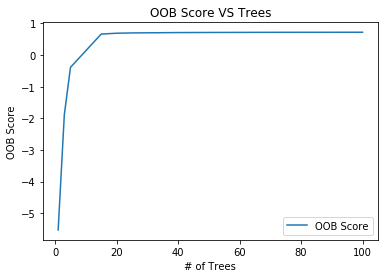

In [43]:
results = []
n_estimator_options = [1, 3, 5, 15, 20, 25, 40, 50, 70, 100]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, random_state=42)
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(trees, 'trees')
    AUC = model.oob_score_
    print('AUC: ', AUC)
    results.append(AUC)
    print (" ")
    
plt.plot(n_estimator_options, results, label='OOB Score')
plt.xlabel('# of Trees')
plt.ylabel('OOB Score')
plt.title('OOB Score VS Trees')
plt.legend(loc="lower right")
plt.show()

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 min samples
AUC:  0.7015777234217195
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 min samples
AUC:  0.7224612878971554
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 min samples
AUC:  0.7293080936961768
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


7 min samples
AUC:  0.7314323082185077
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


9 min samples
AUC:  0.7321933346764886
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


10 min samples
AUC:  0.7325137383973969
 
20 min samples
AUC:  0.7283299422069354
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


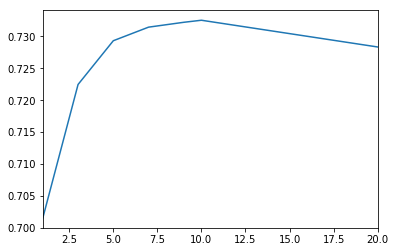

In [44]:
results_min_samples = []
min_samples_leaf_options = [1, 3, 5, 7, 9, 10, 20]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=25, oob_score=True, n_jobs=-1, random_state=42, max_features="auto", min_samples_leaf=min_samples)
    model.fit(X_train, y_train)
    print(min_samples, "min samples")
    auc = model.oob_score_
    print('AUC: ', auc)
    results_min_samples.append(auc)
    print (" ")
    
pd.Series(results_min_samples, min_samples_leaf_options).plot()


#### Rebuild Random Forest with the updated parameters

In [45]:
model_2 = RandomForestRegressor(n_jobs = -1,oob_score=True, random_state=40,n_estimators=25, max_depth=25,min_samples_leaf =10)
model_2.fit(X_train,y_train)
y_pred2 = model_2.predict(X_test) 
print('Mean Squared Error:', mean_squared_error(y_test, y_pred2))

Mean Squared Error: 387.0157841114303


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#### Tuning Gradient Boosting 

In [46]:
results_depth=[]
for depth in [2,3,4,5,10]:
    clf = GradientBoostingRegressor(max_depth=depth)
    clf.fit(X_train, y_train)
    results_depth.append(
        {
            'max_depth': depth,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })
    
# Display Results
max_depth_lr = pd.DataFrame(results_depth).set_index('max_depth').sort_index()
max_depth_lr

,test_error,train_error
max_depth,,
2,414.980925,419.464119
3,378.443904,382.449784
4,362.974612,362.663816
5,356.168635,351.657266
10,372.372811,210.680851


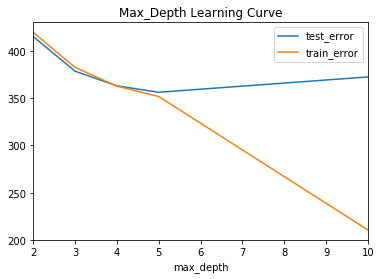

In [47]:
max_depth_lr.plot(title="Max_Depth Learning Curve")

In [48]:
results_learning=[]
for rate in [0.1,0.15,0.2,0.25,0.3]:
    clf = GradientBoostingRegressor(learning_rate=rate)
    clf.fit(X_train, y_train)
    results_learning.append(
        {
            'learning_rate': rate,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })
    
# Display Results
learning_rate_lr = pd.DataFrame(results_learning).set_index('learning_rate').sort_index()
learning_rate_lr

,test_error,train_error
learning_rate,,
0.10,378.443904,382.449784
0.15,363.056889,367.018421
0.20,359.539045,363.694863
0.25,358.818630,362.631860
0.30,357.384792,360.833278


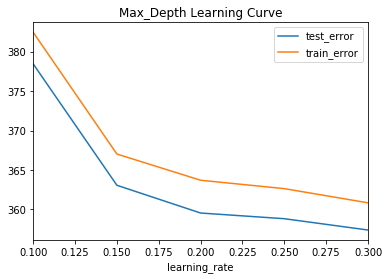

In [49]:
learning_rate_lr.plot(title="Max_Depth Learning Curve")

#### Building Gradient Boosting Model with the updated parameters

In [50]:
gbrt = GradientBoostingRegressor(max_depth=5, n_estimators=25,learning_rate=0.2)
gbrt.fit(X_train,y_train)
# Prediction
y_pred_3 = gbrt.predict(X_test) 
y_pred_3

array([119.3780011 , 139.18212617,  79.43207537, ..., 130.70374142,
       115.0473966 , 161.86916612])

In [51]:
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_3))

Mean Squared Error: 382.4728776522305


### ----  5-Fold Cross Validation ----

In [58]:
#initialize model list and dicts
models = []
mean_mse = {}
cv_std = {}
res = {}

#define number of processes to run in parallel
num_procs = 2


In [59]:
#create models -- hyperparameter tuning already done by hand for each model
lr_cv = LinearRegression()
rf_tuned = RandomForestRegressor(n_estimators=150, n_jobs=num_procs, max_depth=25)
gbm_tuned = GradientBoostingRegressor(n_estimators=100, max_depth=5, loss='ls',learning_rate = 0.18)
                      
models.extend([lr_cv, rf_tuned, gbm_tuned])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, X, y, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Beginning cross validation

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Average MSE:
 923.2979151584477
Standard deviation during CV:
 6.709800308618867

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Average MSE:
 414.20187679396645
Standard deviation during CV:
 0.138708820655296

Model:
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.18, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weigh

### ---- 10 Select best model  ----

In [71]:
#choose model with lowest mse
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print_summary(model, mean_mse, cv_std)

#train model on entire dataset
model.fit(X, y)
test_set = test_set.drop(['jobId','companyId'],axis=1)
#create predictions based on test data
predictions = model.predict(test_set)



Predictions calculated using model with lowest MSE:

Model:
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.18, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
Average MSE:
 361.8010723971129
Standard deviation during CV:
 0.4113897257670942


## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk, and scores the "test" dataset
def salary_prediction_pipeline(train_features, train_target, test_features):
    
    #load data
    print('Loading data...')
    train_features = load_file(train_features)
    train_target = load_file(train_target)
    test_features = load_file(test_features)
    
    #merge data
    print('Merging data...')
    merged_df = merge_data(train_features, train_target, 'jobId')
    
    #clean data
    print('Cleaning data...')
    train_cleaned = clean_data(merged_df)
    
    
    
    
    
    
    
    
    

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

#save feature importance results
save_results(model, mean_mse[model], predictions, feature_importances)

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data